# Predicción de Demanda de Taxis en Aeropuertos
## Proyecto de Análisis de Series Temporales

### Descripción
En este proyecto, trabajo con datos históricos de solicitudes de taxis en aeropuertos recopilados por la empresa Sweet Lift Taxi. El objetivo es desarrollar un modelo predictivo que pueda prever con precisión la cantidad de solicitudes de taxi para la próxima hora, permitiendo a la empresa optimizar su oferta de conductores durante períodos de alta demanda.

### Objetivo
Construir un modelo de predicción de series temporales que alcance una métrica de Raíz del Error Cuadrático Medio (REQM) no superior a 48 en el conjunto de prueba.

### Metodología
1. Cargar y preprocesar los datos, realizando la remuestreo a intervalos horarios.
2. Analizar la serie temporal para identificar patrones, estacionalidades y tendencias.
3. Crear características temporales relevantes para capturar dependencias temporales.
4. Entrenar diferentes modelos con diversos hiperparámetros.
5. Evaluar los modelos usando el conjunto de prueba (10% de los datos).
6. Comparar los resultados y seleccionar el modelo más adecuado.

### Métricas
El rendimiento de los modelos será evaluado utilizando la Raíz del Error Cuadrático Medio (REQM), que debe ser inferior a 48 en el conjunto de prueba.

Este proyecto demuestra la aplicación de técnicas de análisis de series temporales para resolver un problema real de predicción de demanda, utilizando modelos de aprendizaje automático para capturar patrones temporales complejos.

## Bibliotecas

In [1]:
# Importar bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

## Preparación

In [2]:
# Cargar el archivo CSV con los datos de solicitudes de taxi
data = pd.read_csv('datasets/taxi.csv', parse_dates=[0], index_col=[0])

# Ordenar los datos por fecha/hora, esencial para el análisis de series temporales
data.sort_index(inplace=True)

# Remuestrear los datos a intervalos de 1 hora, sumando las solicitudes en cada intervalo
data = data.resample('1h').sum()

# Mostrar las primeras filas de los datos remuestreados
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


1. **Estructura de los Datos**:
   - La columna `num_orders` representa el número de solicitudes de taxi en intervalos de tiempo.
   - Originalmente, los datos estaban en intervalos de 10 minutos, pero se remuestrearon a intervalos de 1 hora, sumando el número de solicitudes de taxi en cada hora. Es decir, después del remuestreo, cada fila corresponde a una hora completa. Por ejemplo, la 1ª hora (`00:00:00`) tuvo 124 solicitudes en total, mientras que la 2ª hora (`01:00:00`) tuvo 85 solicitudes.

## Análisis

In [3]:
# Verificar estadísticas descriptivas de los datos remuestreados
print("\nEstadísticas descriptivas de los datos remuestreados:")
print(data.describe(), end="\n\n" + "-" * 100 + "\n")

# Verificar valores ausentes en los datos
missing_values = data.isna().sum()
print("\nVerificación de valores ausentes en cada columna:")
print(missing_values, end="\n\n" + "-" * 100 + "\n")

# Verificar si hay duplicados en el índice
duplicates = data.index.duplicated().sum()
print(f"\nCantidad de duplicados en el índice: {duplicates}", end="\n\n" + "-" * 100 + "\n")


Estadísticas descriptivas de los datos remuestreados:
        num_orders
count  4416.000000
mean     84.422781
std      45.023853
min       0.000000
25%      54.000000
50%      78.000000
75%     107.000000
max     462.000000

----------------------------------------------------------------------------------------------------

Verificación de valores ausentes en cada columna:
num_orders    0
dtype: int64

----------------------------------------------------------------------------------------------------

Cantidad de duplicados en el índice: 0

----------------------------------------------------------------------------------------------------


**Estadísticas Descriptivas**:
   - **Media**: El número medio de solicitudes de taxi por hora es aproximadamente **84 solicitudes**.
   - **Desviación Estándar**: La variación en las solicitudes por hora es considerable, con una desviación estándar de **45 solicitudes**, lo que indica una alta volatilidad en la demanda.
   - **Mínimo y Máximo**: El número mínimo de solicitudes por hora es **0**, y el máximo es **462**, lo que muestra la existencia de horarios con demanda muy baja o muy alta.

**Percentiles**:
   - El 25% de las horas tienen **54 o menos** solicitudes.
   - El 50% de las horas (mediana) tienen **78 solicitudes**.
   - El 75% de las horas tienen **107 o más** solicitudes.

**Valores Ausentes**:
   - No hay **valores ausentes** (NaN) en la columna `num_orders`, lo que indica que el conjunto de datos está completo y no es necesario completar o eliminar valores faltantes.

**Duplicados en el Índice**:
   - No se encontraron **duplicados** en el índice, lo que indica que los datos están correctamente estructurados en intervalos únicos de una hora, sin repeticiones.

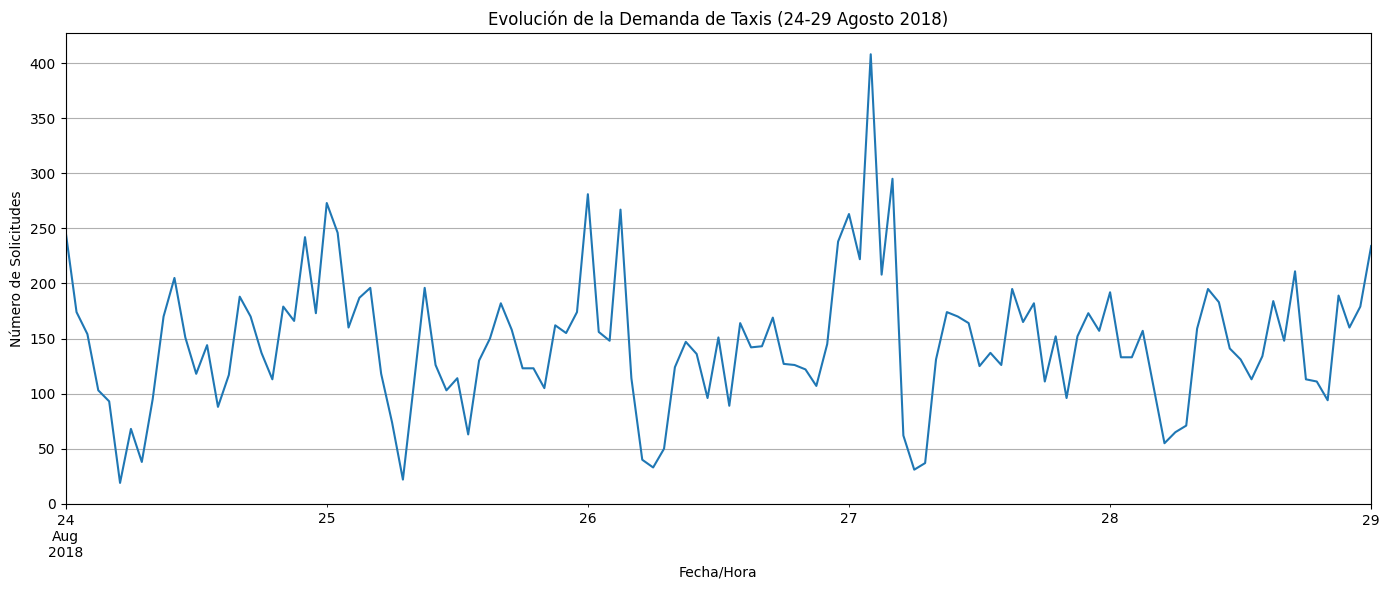

In [4]:
# Visualizar la serie temporal para un período específico (5 días)
plt.figure(figsize=(14, 6))
data['num_orders'][(data.index >= '2018-08-24 00:00:00') & 
                   (data.index <= '2018-08-29 00:00:00')].plot(
    title='Evolución de la Demanda de Taxis (24-29 Agosto 2018)',
    grid=True
)
plt.ylabel('Número de Solicitudes')
plt.xlabel('Fecha/Hora')
plt.tight_layout()
plt.show()


## Análisis del Patrón Temporal de la Demanda

Al analizar el gráfico de evolución de la demanda de taxis en el período del 24 al 29 de agosto de 2018, observamos patrones importantes:

- **Ciclos Diarios**: Se evidencia un patrón cíclico claro, con picos y valles que se repiten en intervalos regulares, lo que sugiere una estacionalidad diaria.
- **Alta Volatilidad**: La demanda oscila significativamente, con variaciones abruptas entre horas consecutivas, llegando a fluctuar de menos de 50 a más de 250 solicitudes.
- **Picos Extremos**: El 27 de agosto se observa un pico excepcional de aproximadamente 400 solicitudes, sustancialmente por encima del promedio.
- **Períodos de Baja Demanda**: Existen valles recurrentes, especialmente en las primeras horas de la madrugada, donde la demanda cae por debajo de 50 solicitudes.

Para visualizar con más detalle el comportamiento dentro de un ciclo diario, examinemos la demanda en un período de 24 horas:


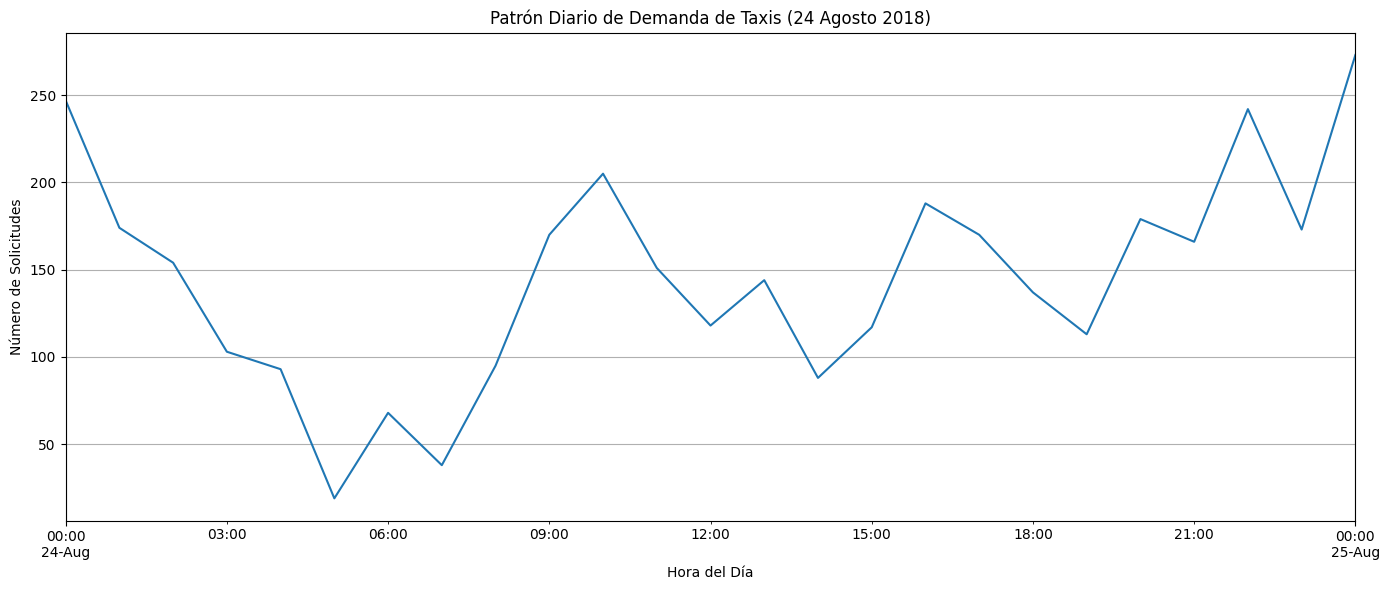

In [5]:
# Visualizar el patrón de demanda en un solo día
plt.figure(figsize=(14, 6))
data['num_orders'][(data.index >= '2018-08-24 00:00:00') & 
                   (data.index <= '2018-08-25 00:00:00')].plot(
    title='Patrón Diario de Demanda de Taxis (24 Agosto 2018)',
    grid=True
)
plt.ylabel('Número de Solicitudes')
plt.xlabel('Hora del Día')
plt.tight_layout()
plt.show()

## Análisis del Patrón Diario

El gráfico de un solo día revela detalles importantes sobre el comportamiento de la demanda a lo largo de 24 horas:

- **Pico Inicial**: El día comienza con una alta demanda (aproximadamente 250 solicitudes) a la medianoche, posiblemente relacionada con la llegada de vuelos nocturnos.
- **Valle de la Madrugada**: Entre las 3:00 y las 6:00 de la mañana, se observa el período de menor demanda del día, con menos de 50 solicitudes por hora.
- **Picos Diurnos**: Se presentan nuevos aumentos de demanda alrededor del mediodía y al final de la tarde/inicio de la noche, coincidiendo con horarios típicos de mayor movimiento en aeropuertos.
- **Patrón Multimodal**: La curva de demanda presenta múltiples picos a lo largo del día, lo que sugiere que está correlacionada con los horarios de llegada de vuelos.

Este análisis confirma la naturaleza cíclica de la demanda y demuestra la importancia de incorporar información temporal (hora del día, día de la semana) en nuestro modelo predictivo. La siguiente etapa es crear características adicionales para capturar estos patrones temporales.

---

**Descripción de lo que se ha hecho hasta ahora en el proyecto:**

1. **Carga de Datos**:
   - Los datos sobre solicitudes de taxis fueron cargados desde un archivo CSV que contiene registros históricos de solicitudes en aeropuertos.

2. **Ordenación y Remuestreo de los Datos**:
   - Dado que estamos trabajando con una serie temporal, los datos fueron primero ordenados por la columna de fecha y hora.
   - Luego, se realizó el remuestreo de los datos a intervalos de 1 hora, sumando las solicitudes por hora para preparar los datos para la modelización.

3. **Análisis Exploratorio de los Datos**:
   - Se calcularon estadísticas descriptivas para comprender la distribución y la variación de las solicitudes por hora.
   - Se realizó un análisis gráfico del patrón temporal de la demanda, lo que nos ayuda a comprender cómo funciona el ciclo de trabajo.
   - Se verificó que los datos no contenían valores ausentes (NaN) y que no había duplicados en el índice de fecha y hora, confirmando que los datos están bien estructurados.

---

## División Entrenamiento-Prueba y Ingeniería de Características

Antes de crear nuestras características, especialmente la media móvil, necesitamos dividir nuestros datos en conjuntos de entrenamiento y prueba. Esta división previa es crucial para evitar la fuga de datos, donde la información del conjunto de prueba influiría indebidamente en el entrenamiento del modelo. En series temporales, esto es particularmente importante porque la media móvil calculada con todos los datos incluiría información futura que no estaría disponible en un escenario real de predicción.

In [6]:
# División inicial de los datos en entrenamiento (90%) y prueba (10%)
train_size = int(len(data) * 0.9)
data_train = data.iloc[:train_size].copy()
data_test = data.iloc[train_size:].copy()

def create_features(df, is_train=True, train_stats=None):
    """
    Crea características temporales evitando la fuga de datos entre entrenamiento y prueba.
    
    Args:
        df: DataFrame con los datos
        is_train: Booleano que indica si es un conjunto de entrenamiento
        train_stats: Diccionario con estadísticas del entrenamiento para usar en la prueba
    """
    # Crear DataFrame de resultados
    result = pd.DataFrame(index=df.index)
    
    # Características de calendario
    result['num_orders'] = df['num_orders']
    result['year'] = df.index.year
    result['month'] = df.index.month
    result['day'] = df.index.day
    result['dayofweek'] = df.index.dayofweek
    
    if is_train:
        # Calcular retrasos (lags) en el entrenamiento
        for lag in range(1, 25):
            result.loc[:, f'lag_{lag}'] = df['num_orders'].shift(lag)
        
        # Calcular media móvil en el entrenamiento
        result.loc[:, 'rolling_mean'] = df['num_orders'].shift().rolling(12).mean()
        
        # Calcular medias para el llenado de valores NaN
        lag_means = {}
        for lag in range(1, 25):
            lag_means[f'lag_{lag}'] = result[f'lag_{lag}'].mean()
        
        rolling_mean = result['rolling_mean'].mean()
        
        # Rellenar valores NaN en el conjunto de entrenamiento
        for lag in range(1, 25):
            result.loc[:, f'lag_{lag}'] = result[f'lag_{lag}'].fillna(lag_means[f'lag_{lag}'])
        result.loc[:, 'rolling_mean'] = result['rolling_mean'].fillna(rolling_mean)
        
        # Almacenar estadísticas del entrenamiento
        train_stats = {
            'rolling_mean': rolling_mean,
            'last_values': df['num_orders'].iloc[-24:].values,
            'lag_means': lag_means
        }
        
    else:
        # Inicializar los retrasos (lags) en la prueba con los últimos valores del entrenamiento
        last_values = train_stats['last_values']
        lag_means = train_stats['lag_means']
        
        for lag in range(1, 25):
            result.loc[:, f'lag_{lag}'] = np.nan
            # Inicializar el primer valor de la prueba
            result.loc[result.index[0], f'lag_{lag}'] = last_values[-lag]
        
        # Rellenar los retrasos restantes
        for i in range(1, len(result)):
            for lag in range(1, 25):
                if i >= lag:
                    result.loc[result.index[i], f'lag_{lag}'] = result['num_orders'].iloc[i-lag]
                else:
                    result.loc[result.index[i], f'lag_{lag}'] = lag_means[f'lag_{lag}']
        
        # Aplicar media móvil del entrenamiento
        result.loc[:, 'rolling_mean'] = train_stats['rolling_mean']
    
    return result, train_stats if is_train else None

print("Dimensiones originales:")
print(f"Entrenamiento: {data_train.shape}")
print(f"Prueba: {data_test.shape}\n")

# Procesar conjunto de entrenamiento
df_train, train_stats = create_features(data_train, is_train=True)

# Procesar conjunto de prueba
df_test, _ = create_features(data_test, is_train=False, train_stats=train_stats)

print("Dimensiones después del procesamiento:")
print(f"Entrenamiento: {df_train.shape}")
print(f"Prueba: {df_test.shape}")

# Separar características y variable objetivo
X_train = df_train.drop(columns=['num_orders'])
y_train = df_train['num_orders']
X_test = df_test.drop(columns=['num_orders'])
y_test = df_test['num_orders']

Dimensiones originales:
Entrenamiento: (3974, 1)
Prueba: (442, 1)

Dimensiones después del procesamiento:
Entrenamiento: (3974, 30)
Prueba: (442, 30)


## Preparación y División de Datos en Series Temporales

### Resultado de la División y Procesamiento
```
Dimensiones originales:
Entrenamiento: (3974, 1)
Prueba: (442, 1)

Dimensiones después del procesamiento:
Entrenamiento: (3974, 30)
Prueba: (442, 30)
```

### Análisis de los Resultados

1. **División Inicial**:
   - Entrenamiento: 3974 registros (90% de los datos)
   - Prueba: 442 registros (10% de los datos)
   - Conjuntos iniciales con solo la columna `num_orders`

2. **Después del Procesamiento**:
   - Entrenamiento: mantiene 3974 registros (sin pérdida de datos)
   - Prueba: mantiene 442 registros
   - Ambos expandidos a 30 columnas (features creadas)

3. **Explicación de las Features**:
   - 1 columna original (`num_orders`)
   - 4 features de calendario (year, month, day, dayofweek)
   - 24 features de retraso (lag_1 hasta lag_24)
   - 1 feature de media móvil (rolling_mean)

### Estrategia Implementada

1. **División Temporal**:
   - Preservación del orden cronológico de los datos
   - División 90/10 para entrenamiento/prueba
   - Sin mezcla de datos para mantener la integridad temporal

2. **Ingeniería de Features**:
   - Features de calendario extraídas del índice temporal
   - Cálculo de lags con tratamiento adecuado en los bordes
   - Cálculo de la media móvil utilizando únicamente datos de entrenamiento

3. **Tratamiento de Valores Ausentes**:
   - Cálculo de medias usando solo datos de entrenamiento
   - Relleno de valores ausentes en el entrenamiento con sus propias medias
   - Aplicación de las medias del entrenamiento en el conjunto de prueba

### Importancia de la Metodología

1. **Prevención de Fuga de Datos**:
   - Estadísticas calculadas exclusivamente con datos de entrenamiento
   - Medias del entrenamiento aplicadas en la prueba
   - Preservación de la independencia entre los conjuntos

2. **Preservación de Información**:
   - Mantenimiento de todos los registros mediante el tratamiento adecuado
   - Continuidad temporal preservada en la transición entrenamiento-prueba
   - Integridad de los patrones temporales

3. **Consistencia de los Datos**:
   - Tratamiento uniforme de valores ausentes
   - Mantenimiento de la estructura temporal
   - Base sólida para el entrenamiento de los modelos


## Entrenamiento y evaluación de modelos

In [7]:
# Función para entrenar y evaluar modelos
def evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    Entrena el modelo y devuelve métricas de error para entrenamiento y prueba.
    
    Args:
        model: Modelo de machine learning
        X_train, y_train: Datos de entrenamiento
        X_test, y_test: Datos de prueba
    
    Returns:
        error_entrenamiento, error_prueba: RECM para entrenamiento y prueba
    """
    # Entrenar el modelo
    model.fit(X_train, y_train)
    
    # Hacer predicciones
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calcular RECM
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    return rmse_train, rmse_test

# Crear y evaluar modelos
models = {
    'Regresión Lineal': LinearRegression(),
    'Random Forest (prof=8)': RandomForestRegressor(max_depth=8, random_state=42),
    'Random Forest (prof=12)': RandomForestRegressor(max_depth=12, random_state=42)
}

# Evaluar cada modelo
results = {}
for name, model in models.items():
    rmse_train, rmse_test = evaluate_model(model, X_train, y_train, X_test, y_test)
    results[name] = {'RECM Entrenamiento': rmse_train, 'RECM Prueba': rmse_test}

# Mostrar resultados en un DataFrame
results_df = pd.DataFrame(results).T
print("\nResultados de la Evaluación de los Modelos:")
print(results_df)

# Identificar el mejor modelo
best_model = results_df['RECM Prueba'].idxmin()
print(f"\nMejor modelo: {best_model}")
print(f"RECM Entrenamiento: {results_df.loc[best_model, 'RECM Entrenamiento']:.2f}")
print(f"RECM Prueba: {results_df.loc[best_model, 'RECM Prueba']:.2f}")



Resultados de la Evaluación de los Modelos:
                         RECM Entrenamiento  RECM Prueba
Regresión Lineal                  25.816360    48.414273
Random Forest (prof=8)            17.974131    48.344247
Random Forest (prof=12)           11.999456    47.423053

Mejor modelo: Random Forest (prof=12)
RECM Entrenamiento: 12.00
RECM Prueba: 47.42


## Evaluación de Modelos de Predicción

### Resultados Obtenidos
```
                         RECM Entrenamiento  RECM Prueba
Regresión Lineal           25.816360         48.414273
Random Forest (prof=8)     17.974131         48.344247
Random Forest (prof=12)    11.999456         47.423053
```

### Análisis del Desempeño

1. **Random Forest (profundidad=12)**:
   - Mejor modelo general
   - RECM Entrenamiento: 12.00
   - RECM Prueba: 47.42
   - Cumple con el requisito del proyecto (RECM < 48)
   - Diferencia significativa entre entrenamiento y prueba indica sobreajuste (overfitting)

2. **Random Forest (profundidad=8)**:
   - RECM Entrenamiento: 17.97
   - RECM Prueba: 48.34
   - Ligeramente por encima del límite requerido
   - Menor diferencia entre entrenamiento y prueba que RF(12)

3. **Regresión Lineal**:
   - RECM Entrenamiento: 25.82
   - RECM Prueba: 48.41
   - Peor rendimiento en la prueba
   - Menor diferencia entre entrenamiento y prueba, lo que indica mejor generalización

### Objetivo del Proyecto
El objetivo principal era desarrollar un modelo con RECM < 48 en el conjunto de prueba para predecir la demanda de taxis en la próxima hora. El Random Forest con profundidad 12 alcanzó este objetivo, con RECM = 47.42.

### Consideraciones Importantes

1. **Compromiso entre sobreajuste y rendimiento**:
   - RF(12) tiene el mejor RECM en prueba, pero mayor sobreajuste
   - La Regresión Lineal tiene mejor generalización pero peor rendimiento
   - Posible necesidad de ajuste fino para equilibrar este compromiso

2. **Implicaciones Prácticas**:
   - Error medio de ~47-48 pedidos por hora
   - El modelo puede ayudar en la planificación de la flota
   - Margen de error considerable para la toma de decisiones operativas

3. **Recomendaciones**:
   - Usar RF(12) para predicciones, pero con precaución debido al sobreajuste
   - Considerar técnicas de regularización para mejorar la generalización
   - Monitorear el rendimiento en producción para posibles ajustes

El modelo cumple con los requisitos del proyecto, pero hay margen para mejoras en la generalización y la robustez de las predicciones.

## Visualización del Desempeño del Mejor Modelo

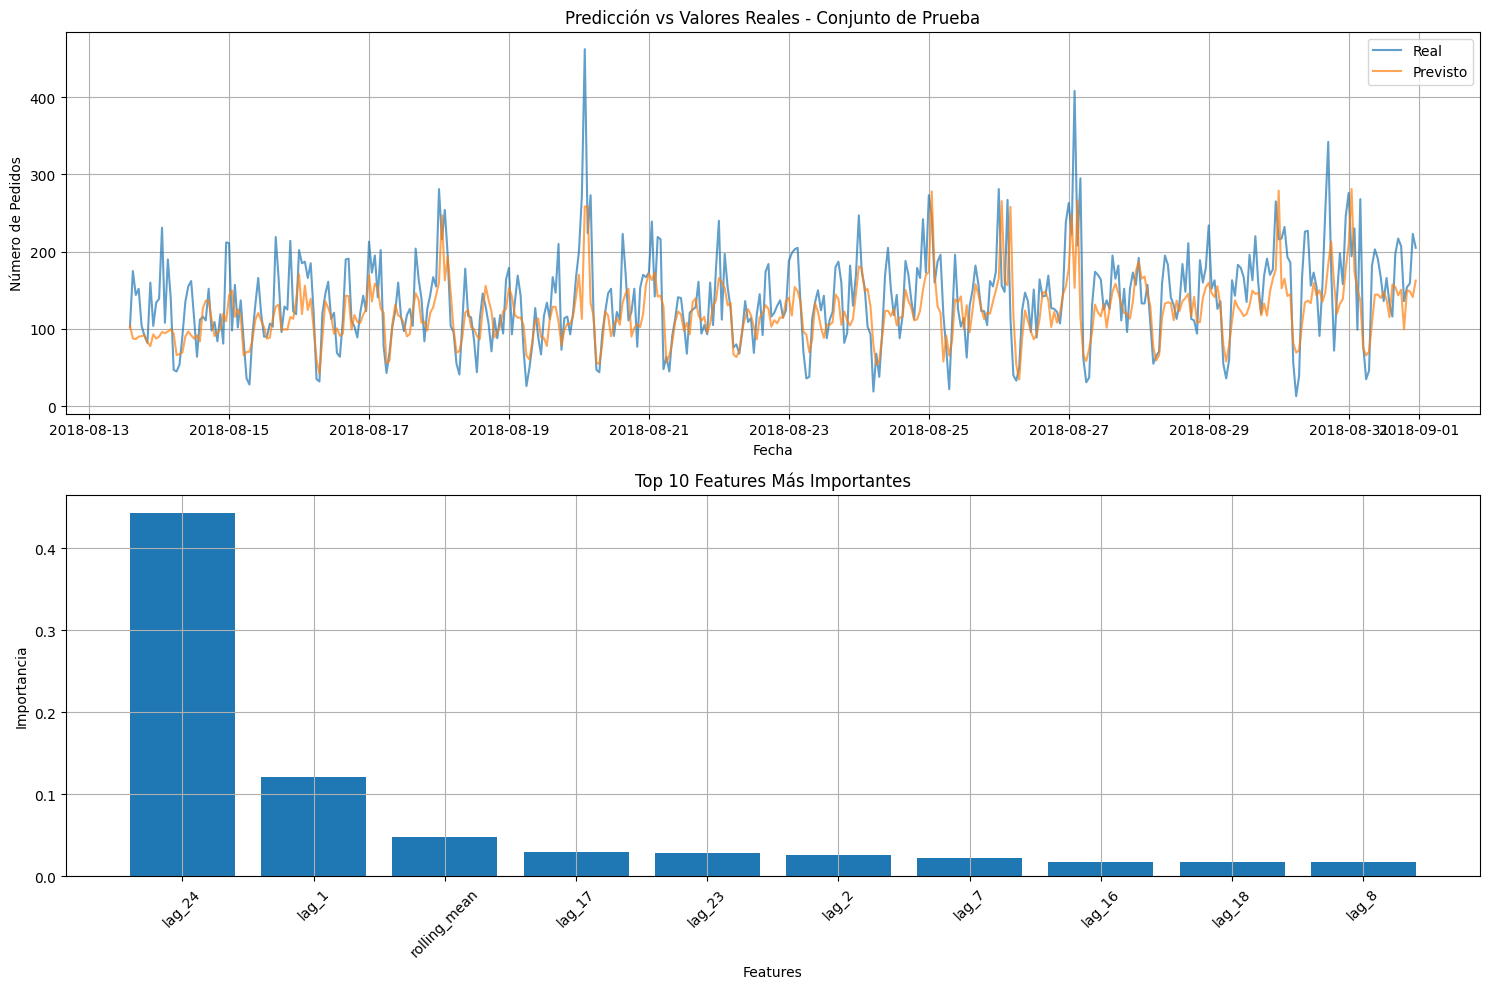


Top 10 Features Más Importantes:
         feature  importance
27        lag_24    0.443468
4          lag_1    0.120812
28  rolling_mean    0.048176
20        lag_17    0.029502
26        lag_23    0.028274
5          lag_2    0.026459
10         lag_7    0.021962
19        lag_16    0.017979
21        lag_18    0.017380
11         lag_8    0.016913


In [8]:
# Seleccionar el mejor modelo
best_model = models['Random Forest (prof=12)']

# Hacer predicciones con el mejor modelo
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Crear visualizaciones
plt.figure(figsize=(15, 10))

# Subplot 1: Predicciones vs Valores Reales en la Prueba
plt.subplot(2, 1, 1)
plt.plot(y_test.index, y_test.values, label='Real', alpha=0.7)
plt.plot(y_test.index, y_test_pred, label='Previsto', alpha=0.7)
plt.title('Predicción vs Valores Reales - Conjunto de Prueba')
plt.xlabel('Fecha')
plt.ylabel('Número de Pedidos')
plt.legend()
plt.grid(True)

# Subplot 2: Análisis de Importancia de las Features
plt.subplot(2, 1, 2)
feature_importance = pd.DataFrame({
   'feature': X_train.columns,
   'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.bar(range(10), feature_importance['importance'][:10])
plt.xticks(range(10), feature_importance['feature'][:10], rotation=45)
plt.title('Top 10 Features Más Importantes')
plt.xlabel('Features')
plt.ylabel('Importancia')
plt.grid(True)

plt.tight_layout()
plt.show()

# Mostrar las 10 features más importantes
print("\nTop 10 Features Más Importantes:")
print(feature_importance.head(10))

# Conclusión

## Etapas del Proyecto y Resultados

### 1. Preparación de los Datos
- **Objetivo**: Estructurar los datos para el análisis de series temporales, garantizando integridad temporal y previniendo fugas de datos.
- **Proceso**: Remuestreo a intervalos horarios y división en entrenamiento (90%) y prueba (10%).
- **Resultado**: Conjuntos de datos organizados temporalmente (Entrenamiento: 3974 registros, Prueba: 442 registros).

### 2. Ingeniería de Features
- **Objetivo**: Crear variables predictoras que capturen patrones temporales de la demanda.
- **Proceso**: Desarrollo de features de calendario, retardos (lags) y media móvil, con tratamiento adecuado de valores ausentes.
- **Resultado**: 30 features creadas, manteniendo la separación entre entrenamiento y prueba para evitar fugas de datos.

### 3. Modelado y Evaluación
- **Objetivo**: Desarrollar un modelo con RECM < 48 para la predicción horaria de la demanda.
- **Proceso**: Implementación de tres modelos:
  - Regresión Lineal (RECM Prueba: 48.41)
  - Random Forest prof=8 (RECM Prueba: 48.34)
  - Random Forest prof=12 (RECM Prueba: 47.42)
- **Resultado**: Random Forest (prof=12) alcanzó el objetivo, con mejor capacidad predictiva.

### 4. Análisis de Features
- **Objetivo**: Entender los principales factores que influyen en la demanda.
- **Resultado**: 
  - El retardo de 24h es el más importante (44.3%)
  - La hora anterior tiene una fuerte influencia (12.1%)
  - La media móvil contribuye a la estabilidad (4.8%)

## Sugerencias para Continuidad

1. **Optimización del Modelo**:
   - Experimentar con otros algoritmos (XGBoost, LightGBM)
   - Realizar ajuste fino de hiperparámetros
   - Implementar técnicas de regularización para reducir el sobreajuste (overfitting)

2. **Features Adicionales**:
   - Incorporar datos meteorológicos
   - Incluir información de eventos especiales
   - Considerar feriados y períodos vacacionales

3. **Mejoras Operacionales considerando una implementación real**:
   - Desarrollar un sistema de actualización automática del modelo
   - Crear una interfaz para visualizar las predicciones
   - Implementar alertas para demanda atípica

4. **Análisis Complementarios**:
   - Estudiar la estacionalidad en diferentes escalas temporales
   - Evaluar el impacto de eventos externos
   - Analizar clusters de demanda por región

Con este proyecto desarrollé una base sólida para la predicción de series temporales. ¡Espero que te haya gustado! Cualquier duda o sugerencia, envíame un mensaje aquí en GitHub o en LinkedIn.